<a href="https://colab.research.google.com/github/wakepon21/Masa/blob/master/signate1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

9回目の提出さ

ここまでのtry
*   Light GBM、特徴量12個くらい。MinMaxScalerで正規化したけど、不必要かも
*   基準を0.1以上をOKとしたらクリアになった。？？？？怪しいな
*   crossvalidationがちゃんと働いてないな。
*　 cataegorical featuresという形でもうできることがわかったぞ


---


今後の課題
*   optunaを入れて調整しよう
*   過学習の判断をできるようにしよう
*   Minmaxとかの正規化ってcategoricaldataにもやっていいの？
*   
*   


In [2]:
#importまとめ。pandas-profilingは少々導入が面倒
!pip install git+https://github.com/pandas-profiling/pandas-profiling.git
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas_profiling
import seaborn as sns
from pandas_profiling.utils.cache import cache_file
%matplotlib inline

warnings.filterwarnings('ignore')

  Cloning https://github.com/pandas-profiling/pandas-profiling.git to /tmp/pip-req-build-pw854myu
  Running command git clone -q https://github.com/pandas-profiling/pandas-profiling.git /tmp/pip-req-build-pw854myu
     |████████████████████████████████| 71kB 2.5MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 604kB 14.1MB/s 
     |████████████████████████████████| 3.1MB 21.8MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 296kB 48.4MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.9.0rc1-py2.py3-none-any.whl size=258106 sha256=6e6e27cdd42b80d671d447a3337aed19ba0036dcd1069c289c5c228ae090444e
  Stored in directory: /tmp/pip-ephem-wheel-cache-s1w19ln8/wheels/cd/13/75/8fcecd52c706914e90d916ede57f8c74de60e4c9ebc6c2f3b7
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=b71a572b02f44edcd52646903e4109e124e69678d9a74966c3fb826fd2b5b37

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#train,test,submit_sampleのみっつがそろっているか確認
!ls

sample_data


In [5]:
#そろっていなかったら選択
from google.colab import files
train_up = files.upload()

Saving submit_sample.csv to submit_sample.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [116]:
!ls

sample_data		       submit_sample.csv  train.csv
submission_lightgbm_kfold.csv  test.csv


In [180]:
train = pd.read_csv("train.csv")
len(train)

27100

In [197]:
#上手く列指定ができなかったので、先頭にheaderをつける
sub = pd.read_csv("submit_sample.csv",names=("A","B"))
#test,train,その足し合わせdataの三種を作る
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
train = train.sort_values('y')
#train=train.drop(range(17100,27100))
data = pd.concat([train,test], sort=False)

#特徴量をエンジニアリング
data["job"].replace(['blue-collar','management','technician','admin.','services','unknown','self-employed','entrepreneur','student','retired','unemployed','housemaid'],[0,1,2,3,4,5,6,7,8,9,10,11],inplace=True)
data["loan"].replace(['yes','no'],[1,0],inplace=True)
data["marital"].replace(['married','single','divorced'],[2,1,0],inplace=True)
data['education'].replace(['secondary','tertiary','primary','unknown'],[3,2,1,0],inplace=True)
data["housing"].replace(['yes','no'],[1,0],inplace=True)
data["contact"].replace(['cellular','telephone','unknown'],[2,1,0],inplace=True)
data["poutcome"].replace(['success','failure','unknown','other'],[3,2,1,0],inplace=True)
data["job"] = data["job"].astype(np.int64)
data["month"].replace(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','des'],[3,4,5,6,7,8,9,10,11,0,1,2],inplace=True)
data["year"]=data["month"]*30+data["day"]

#全体のうち、残したいモノだけ選ぶ
all_columns = ['id','age','job','marital','education','default','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome','year']
remain_columns = ['age','job','marital','education','balance','housing','loan','contact','duration','campaign','pdays','previous','poutcome','day','month']
delete_columns = list(set(all_columns)-set(remain_columns))
data.drop(delete_columns, axis=1, inplace=True)

#trainとtestを再度切り分け
train = data[:len(train)]
test = data[len(train):]

In [198]:
len(train)

27100


**------------------cross validation--------------------**


**------light GBM-------**

In [199]:
#train,testを、さらに説明変数Xと、予測変数yに切り分け。y_testは与えられていないのでなし。三種類がでる
y_train = train['y']
X_train = train.drop('y', axis = 1)
X_test = test.drop('y', axis = 1)

# MinmaxScalarを使って正規化。
from sklearn.preprocessing import MinMaxScaler
mmsc = MinMaxScaler()
# 訓練用のデータを正規化する。fit_transformはfit＆transformの略で、情報取得＆正規化の意味
X_train_norm = mmsc.fit_transform(X_train)
# 訓練用データを基準にテストデータも正規化
X_test_norm = mmsc.transform(X_test)
X_train=X_train_norm
X_test=X_test_norm
#正規化するとarrayになっていたので、DataFrameに戻す
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
#Dataflameにしたらheaderが抜けていたので付け直す
X_train.columns=remain_columns
X_test.columns=remain_columns
#この辺のheader周りの操作は無駄なのでできたら修正したい

In [200]:
#欲しいデータが見えているか確認
data

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,31,4,2,3,12294,1,0,2,21,1,101,3,498,0,0,0.0
17687,34,7,2,3,91274,1,0,0,15,7,152,2,54,0,1,0.0
17686,29,3,0,3,49151,0,1,2,7,9,271,3,730,0,1,0.0
17685,29,10,1,2,15822,0,0,2,21,1,158,1,194,0,1,0.0
17684,35,2,2,2,5823,0,0,0,26,7,345,1,189,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,6,2,2,98357,1,0,2,6,9,101,2,417,0,2,NaN
18046,34,0,2,3,29621,1,0,2,12,7,345,1,815,0,1,NaN
18047,34,3,1,3,94260,1,0,0,16,7,121,2,370,0,1,NaN
18048,31,2,1,3,65483,1,0,0,15,7,345,2,41,0,1,NaN


In [201]:
from pandas.plotting import scatter_matrix

In [202]:
remain_columns

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'loan',
 'contact',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'day',
 'month']

In [203]:
X_train

,age,job,marital,education,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,day,month
0,0.132353,0.363636,1.0,1.000000,0.175657,1.0,0.0,1.0,0.666667,0.090909,0.032835,0.50,0.572905,0.0,0.000000
1,0.176471,0.636364,1.0,1.000000,0.900457,1.0,0.0,0.0,0.466667,0.636364,0.049415,0.25,0.063146,0.0,0.333333
2,0.102941,0.272727,0.0,1.000000,0.513894,0.0,1.0,1.0,0.200000,0.818182,0.088101,0.50,0.839265,0.0,0.333333
3,0.102941,0.909091,0.5,0.666667,0.208034,0.0,0.0,1.0,0.666667,0.090909,0.051365,0.00,0.223881,0.0,0.333333
4,0.191176,0.181818,1.0,0.666667,0.116273,0.0,0.0,0.0,0.833333,0.636364,0.112159,0.00,0.218140,0.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,0.397059,0.636364,1.0,0.666667,0.895795,0.0,0.0,0.5,0.066667,0.545455,0.021456,0.00,0.447761,0.0,0.333333
27096,0.176471,1.000000,0.5,0.666667,0.959520,0.0,0.0,0.0,0.966667,0.636364,0.213914,0.00,0.941447,0.0,0.333333
27097,0.367647,0.000000,1.0,0.000000,0.186091,0.0,0.0,0.0,0.500000,0.636364,0.049415,0.50,0.343284,0.0,0.333333
27098,0.500000,0.000000,0.5,1.000000,0.959584,0.0,0.0,0.5,0.033333,0.727273,0.057542,0.25,0.639495,0.0,0.333333


In [204]:
#LightGBMに入れる。
from sklearn.model_selection import KFold
import lightgbm as lgb

y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=10, shuffle=True, random_state=0)

#categorical dataの入れ忘れに注意
categorical_features = ['job','marital','education','housing','loan','contact','duration','poutcome','day','month']

params = {
    'objective': 'binary',
    'max_bin': 800,
    'learning_rate': 0.005,
    'num_leaves': 40
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr,
                                             categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,
                                            categorical_feature=categorical_features)
    model = lgb.train(params, lgb_train,
                                   valid_sets=[lgb_train, lgb_eval],
                                   verbose_eval=10,
                                   num_boost_round=1000,
                                   early_stopping_rounds=10)
    
    oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.27533	valid_1's binary_logloss: 0.254507
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.275781	valid_1's binary_logloss: 0.254465
Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.275627	valid_1's binary_logloss: 0.251768
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.276031	valid_1's binary_logloss: 0.251756
Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.272893	valid_1's binary_logloss: 0.27638
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.273355	valid_1's binary_logloss: 0.276262
Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.272193	valid_1's binary_logloss: 0.282732
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.272642	valid_1's binary_logloss: 0.282658
Training u

In [205]:
#pd.DataFrame(oof_train).to_csv('oof_train_kfold.csv', index=False)

scores = [
    m.best_score['valid_1']['binary_logloss'] for m in models
]
score = sum(scores) / len(scores)
print('===CV scores===')
print(scores)
print(score)

===CV scores===
[0.25446466351256153, 0.25175611726780667, 0.2762619350648959, 0.2826575014867307, 0.28363833179286946, 0.2653250051274514, 0.2716758198381265, 0.2826600370324484, 0.2747866485806981, 0.29241936858058537]
0.2735645428284174


In [220]:
from sklearn.metrics import accuracy_score
percentage=0.075


y_pred_oof = (oof_train > percentage).astype(int)
accuracy_score(y_train, y_pred_oof)

0.12878228782287823

In [221]:
y_sub = sum(y_preds) / len(y_preds)
y_sub = (y_sub > percentage).astype(int)


sub['B'] = y_sub
sub.to_csv('submission_lightgbm_kfold.csv', index=False, header=False)

sum(sub["B"]),len(sub["B"])

(17379, 18050)

In [222]:
len(oof_train)

27100

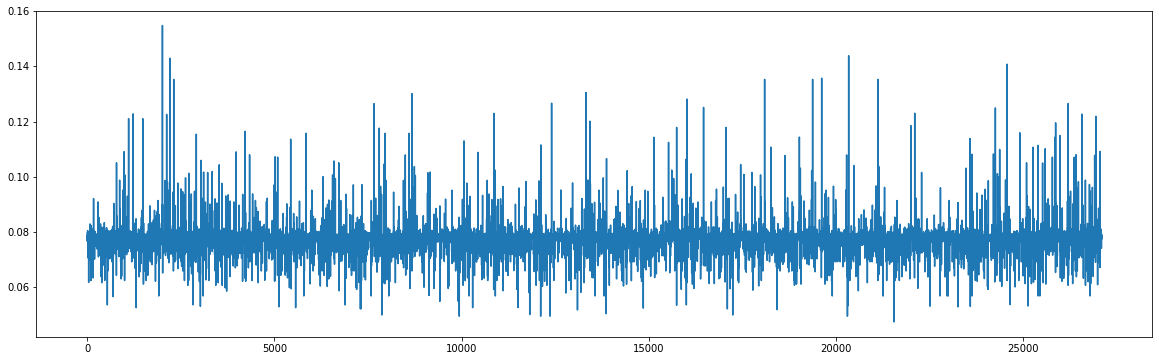

In [223]:
x = range(len(train))
y = oof_train
fig = plt.figure(figsize=(20.0, 6.0))
plt.plot(x, y)

#plt.xlim([0,10000])
plt.show()

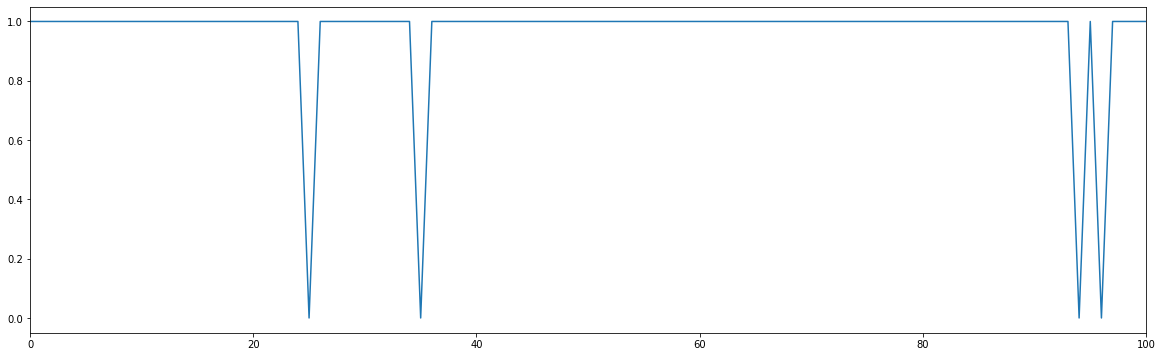

In [224]:

x = range(18050)
y = y_sub
fig = plt.figure(figsize=(20.0, 6.0))
plt.plot(x, y)

plt.xlim([0,100])
plt.show()

In [225]:
sum(sub["B"]),sub["B"]

(17379, 0        1
 1        1
 2        1
 3        1
 4        1
         ..
 18045    1
 18046    1
 18047    1
 18048    1
 18049    1
 Name: B, Length: 18050, dtype: int64)

-----ここまでcross validation-------

In [226]:
files.download('submission_lightgbm_kfold.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>